# The Frozen Lake Problem

The **Frozen Lake** problem is a classic yet powerful simulated environment, perfecto for demonstrating how an agent learns to navigate and make decisions.

Imagine a NxN grid representing a frozen lake.

* **0:** The slippery, frozen ice squares where the agent must move.
* **1:** The agent's strating point.
* **2:** Holes in the ice that the agent must avoid. If the agent falls into a hole, the game ends with no rewards.
* **3:** The goal, which the agent mus reach. Reaching the goal provides the agent with a positive reward.

The **rules** are:

1. **States:** The agent's position on the grid.
2. **Actions:** The agent can choose to movee in four directions: up, down, left or right.
3. **Environment Dynamics:** The ice is slippery. This means that when the agent chooses a direction, it doesn't always move as intended. There is a probability that will slide into an adjacent square. For example, if it chooses `up`, it might end up going `up`, `left` or `right`, with 50% going up and 25% for both left and right.
4. **Rewards:** 
    * Reaching the goal: A reward of **+1**.
    * Falling into a hole: A reward of **-1** and the game ends. Penalizing the agent helps it learn to avoid the holes.
    * Moving on any other square: A reward of **0**.

## Import Libraries

In [2]:
import numpy as np
from TD_methods import double_q_learning_control
from TD_methods import take_action
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

## Compute the Solution

In [3]:
def create_random_frozen_lake(rows, cols, hole_density=0.1, start_pos=(0, 0), goal_pos=None):
    """
    Creates a custom-sized Frozen Lake map with randomly placed holes.

    Args:
        rows (int): The number of rows in the map.
        cols (int): The number of columns in the map.
        hole_density (float): The proportion of holes in the map (between 0 and 1).
        start_pos (tuple): The starting position (row, column coordinates).
        goal_pos (tuple): The goal position (row, column coordinates).
                          If None, it is placed in the bottom-right corner.

    Returns:
        np.array: A NumPy array representing the Frozen Lake map.
    """
    # If no goal is specified, place it in the bottom-right corner
    if goal_pos is None:
        goal_pos = (rows - 1, cols - 1)

    # Create an initial map filled with ice (0)
    frozen_lake = np.zeros((rows, cols), dtype=int)

    # Identify all possible states to place holes
    all_states = [(i, j) for i in range(rows) for j in range(cols)]
    
    # Exclude the start and goal positions from the list of possible hole states
    safe_states = [state for state in all_states if state != start_pos and state != goal_pos]

    # Calculate how many holes are needed and select their positions randomly
    num_holes = int(len(safe_states) * hole_density)
    
    # Ensure the number of holes does not exceed the number of safe states
    num_holes = min(num_holes, len(safe_states))
    
    hole_positions_indices = np.random.choice(len(safe_states), num_holes, replace=False)
    
    for index in hole_positions_indices:
        hole_pos = safe_states[index]
        frozen_lake[hole_pos] = 2  # Place a hole (value 2)

    # Assign the start and goal states
    frozen_lake[start_pos] = 1  # Start (value 1)
    frozen_lake[goal_pos] = 3   # Goal (value 3)

    return frozen_lake

In [4]:
frozen_lake = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3]
])

n, m = frozen_lake.shape

In [5]:
non_terminal_states = []
terminal_states = []
initial_states = []
for i in range(n):
    for j in range(m):
        if frozen_lake[i, j] == 0:
            non_terminal_states.append((i, j))
        elif frozen_lake[i, j] == 1:
            initial_states.append((i, j))
            non_terminal_states.append((i, j))
        elif frozen_lake[i, j] == 2:
            non_terminal_states.append((i, j))
        else:
            terminal_states.append((i, j))

In [6]:
states = non_terminal_states + terminal_states
actions = {}
for state in states:
    i, j = state
    
    # 1. CORNERS
    
    # Top-left corner
    if i == 0 and j == 0:
        actions[state] = ['down', 'right']
        
    # Top-right corner
    elif i == 0 and j == m - 1:
        actions[state] = ['down', 'left']
        
    # Bottom-left corner
    elif i == n - 1 and j == 0:
        actions[state] = ['up', 'right']
        
    # Bottom-right corner
    elif i == n - 1 and j == m - 1:
        actions[state] = ['up', 'left']
        
    # 2. EDGES (excluding corners)
    
    # Top edge
    elif i == 0:
        actions[state] = ['down', 'right', 'left']
        
    # Bottom edge
    elif i == n - 1:
        actions[state] = ['up', 'right', 'left']
        
    # Left edge
    elif j == 0:
        actions[state] = ['up', 'down', 'right']
        
    # Right edge
    elif j == m - 1:
        actions[state] = ['up', 'down', 'left']
        
    # 3. CENTER
    
    # All other states (in the middle of the board)
    else:
        actions[state] = ['up', 'down', 'left', 'right']

In [7]:
def next_step_frozen_lake(state, action):
    """
    Returns a tuple (next_state, reward).
    """
    def isGoal(state):
        if frozen_lake[state] == 3:
            return True
        return False

    def isHole(state):
        if frozen_lake[state] == 2:
            return True
        return False

    def isValid(state):
        i, j = state
        return 0 <= i < n and 0 <= j < m
        
    def move(state, action):
        i, j = state

        if action == "up":
            i2, j2 = i - 1, j
        elif action == "down":
            i2, j2 = i + 1, j
        elif action == "right":
            i2, j2 = i, j + 1 
        elif action == "left":
            i2, j2 = i, j - 1
        else:
            raise ValueError(f"The action {action} is not possible.")
        
        next_state = (i2, j2)
        if isValid(next_state):
            return next_state
        else:
            return state
        
    def returnReward(state, action):
        next_state = move(state=state,
                            action=action)
        
        if isHole(next_state):
            idx = np.random.randint(len(initial_states))
            return (initial_states[idx], -10)
        
        if isGoal(next_state):
            return (next_state, 1)
        
        return (next_state, -1)
    
    if np.random.random() <  0.5:
        return returnReward(state=state,
                            action=action)
    
    actions_state = actions[state]
    idx = np.random.randint(len(actions_state))
    truly_action = actions_state[idx]
    return returnReward(state=state,
                        action=truly_action)
        

In [8]:
Q = {}
for state in states:
    Q[state] = {}
    for action in actions[state]:
        Q[state][action] = 0

In [9]:
policy, Q = double_q_learning_control(non_terminal_states=non_terminal_states,
                          terminal_states=terminal_states,
                          initial_states=initial_states,
                          actions=actions,
                          next_step_fn=next_step_frozen_lake,
                          gamma=1.0,
                          alpha=0.3,
                          epsilon=0.1,
                          num_episodes=100000,
                          initial_Q1=Q,
                          initial_Q2=Q)

## Draw the Solution

In [10]:
def normal_move(state, action):

    def isValid(state):
        i, j = state
        return 0 <= i < n and 0 <= j < m
    
    i, j = state

    if action == "up":
        i2, j2 = i - 1, j
    elif action == "down":
        i2, j2 = i + 1, j
    elif action == "right":
        i2, j2 = i, j + 1 
    elif action == "left":
        i2, j2 = i, j - 1
    else:
        raise ValueError(f"The action {action} is not possible.")
    
    next_state = (i2, j2)
    if isValid(next_state):
        return next_state
    else:
        return state

In [11]:
state = initial_states[0]
action = take_action(state, Q, False)
state, action

((0, 0), 'right')

In [12]:
state = normal_move(state, action)
action = take_action(state, Q, False)
if state in terminal_states:
    print("FINISHED!!!")
state, action

((0, 1), 'right')

In [13]:
state = initial_states[0]
optimal_path = [state]
optimal_actions = []
while state not in terminal_states:
    state = normal_move(state, action)
    optimal_path.append(state)
    action = take_action(state, Q, False)
    optimal_actions.append(action)

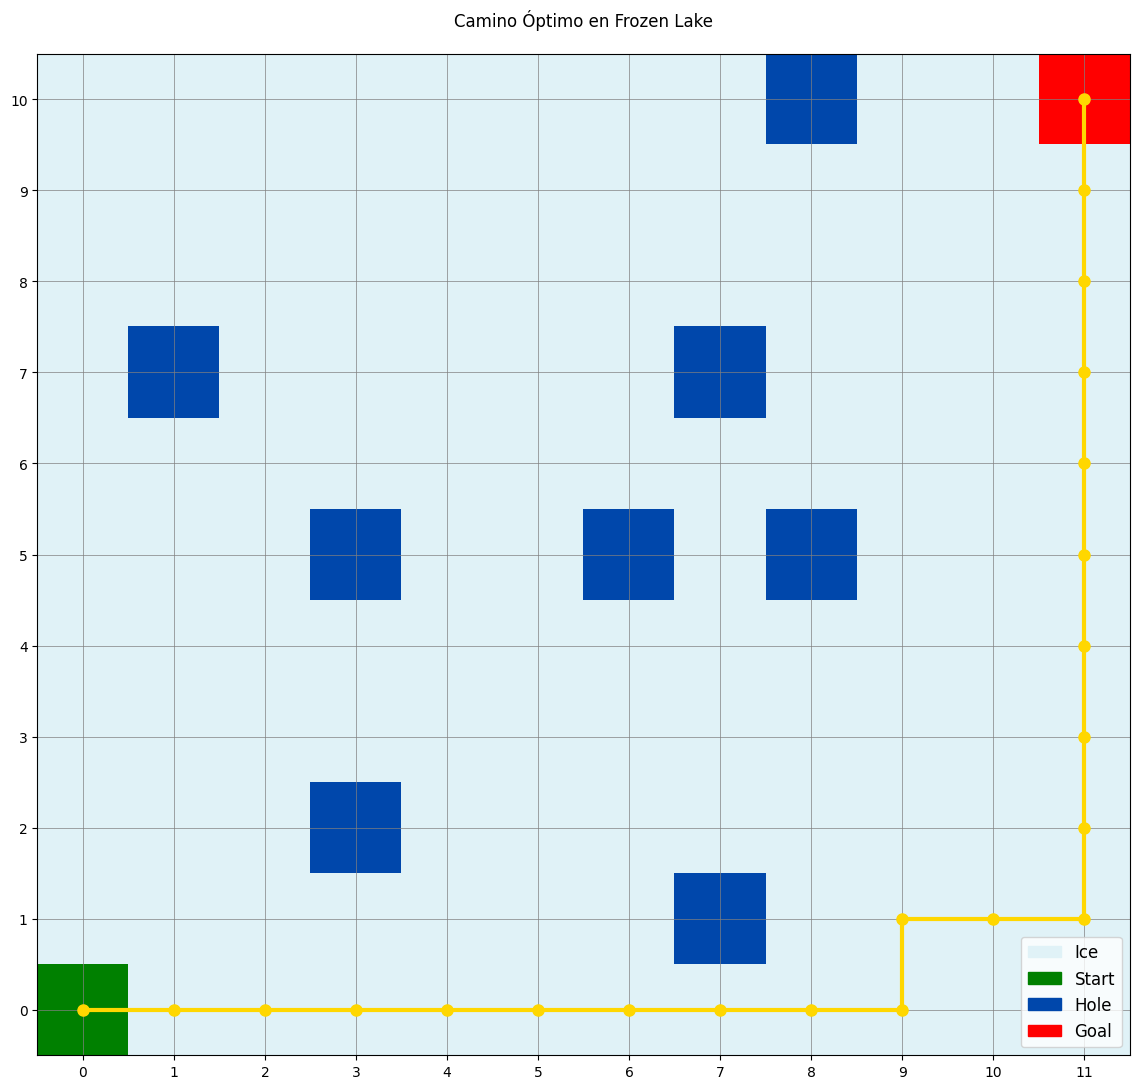

In [14]:
def visualize_frozen_lake(frozen_lake, optimal_path):
    """
    Crea un gráfico de Matplotlib para visualizar el entorno de Frozen Lake
    y el camino óptimo del agente, incluyendo una leyenda.
    """
    n_rows, n_cols = frozen_lake.shape
    
    # 1. Definimos los colores y las etiquetas para la leyenda
    colors = ['#E0F2F7', 'green', '#0047AB', 'red']
    labels = ['Ice', 'Start', 'Hole', 'Goal']
    cmap = ListedColormap(colors)

    # Creamos la figura y los ejes para el gráfico
    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    
    # Pasamos la matriz numérica y el mapa de colores a imshow
    ax.imshow(frozen_lake, cmap=cmap, interpolation='nearest')
    
    # Extraer las coordenadas x, y del camino óptimo
    path_y = [state[0] for state in optimal_path]
    path_x = [state[1] for state in optimal_path]

    # Dibujar la línea del camino óptimo
    ax.plot(path_x, path_y, color='gold', linewidth=3, marker='o', markersize=8)
    
    # 2. Creamos los "parches" para la leyenda
    patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, labels)]
    
    # Añadimos la leyenda al gráfico
    ax.legend(handles=patches, loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)

    # Configuración de los ejes y título
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(np.arange(n_cols))
    ax.set_yticklabels(np.arange(n_rows))
    ax.set_title("Camino Óptimo en Frozen Lake", pad=20)
    ax.grid(True, color='gray', linewidth=0.5)
    
    # Invertimos el eje y para que (0,0) esté en la parte superior
    ax.invert_yaxis()

    plt.tight_layout() # Ajusta el diseño para que la leyenda quepa bien
    plt.show()

# Llama a la función para generar el gráfico
visualize_frozen_lake(frozen_lake, optimal_path)

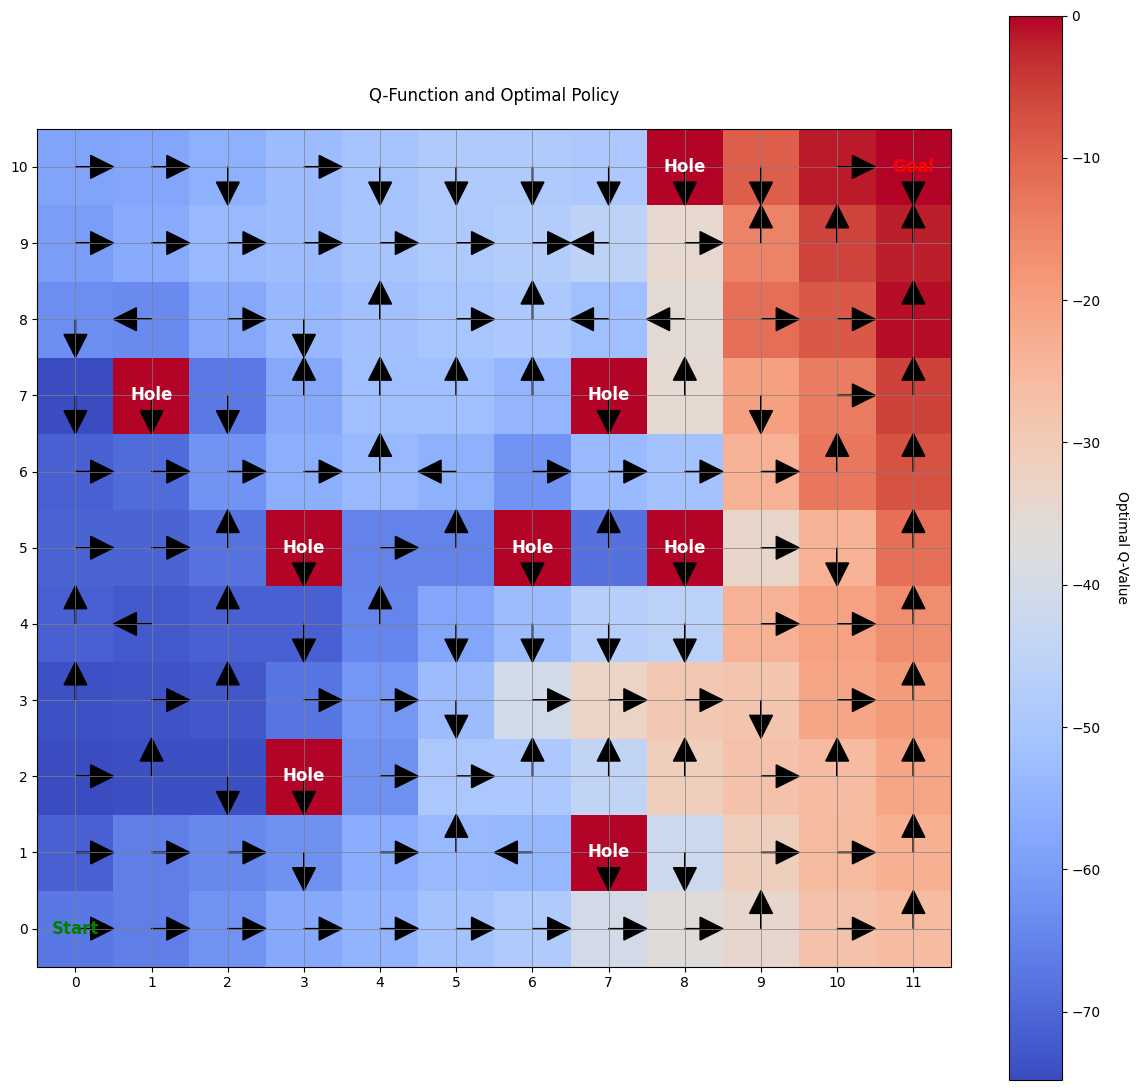

In [15]:
def plot_q_table_heatmap(frozen_lake, Q):
    """
    Generates a heatmap to visualize the optimal policy and Q-values.
    """
    n_rows, n_cols = frozen_lake.shape
    
    # 1. Create a matrix to store the maximum Q-values
    q_values_matrix = np.full(frozen_lake.shape, np.nan)
    
    # 2. Create a dictionary to map actions to arrow directions
    arrow_map = {
        'up': (0, -0.2),    # y-direction, x-direction
        'down': (0, 0.2),
        'left': (-0.2, 0),
        'right': (0.2, 0)
    }

    # 3. Iterate through the Q dictionary to find the best action and its value
    for (i, j), actions in Q.items():
        if actions: # Ignore terminal states that have no actions
            # Find the action with the highest Q-value
            best_action = max(actions, key=actions.get)
            best_q_value = actions[best_action]
            
            # Store the best Q-value in the matrix
            q_values_matrix[i, j] = best_q_value
    
    # 4. Create the figure and axes
    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    
    # Display the heatmap of Q-values
    # Use 'vmin' and 'vmax' to ensure a consistent color scale
    im = ax.imshow(q_values_matrix, cmap='coolwarm', vmin=q_values_matrix[q_values_matrix > -100].min(), vmax=q_values_matrix.max())
    
    # Add the colorbar for the heatmap legend
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Optimal Q-Value', rotation=270, labelpad=20)
    
    # 5. Draw arrows for the optimal policy
    for (i, j), actions in Q.items():
        if actions:
            best_action = max(actions, key=actions.get)
            dx, dy = arrow_map[best_action]
            
            # Draw the arrow in the center of the cell
            ax.arrow(j, i, dx, dy, head_width=0.3, head_length=0.3, fc='black', ec='black')
    
    # 6. Add markers for special states (Start, Hole, Goal)
    for i in range(n_rows):
        for j in range(n_cols):
            if frozen_lake[i, j] == 1:
                ax.text(j, i, 'Start', ha='center', va='center', color='green', fontsize=12, fontweight='bold')
            elif frozen_lake[i, j] == 2:
                ax.text(j, i, 'Hole', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
            elif frozen_lake[i, j] == 3:
                ax.text(j, i, 'Goal', ha='center', va='center', color='red', fontsize=12, fontweight='bold')

    # Configure axes and title
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(np.arange(n_cols))
    ax.set_yticklabels(np.arange(n_rows))
    ax.set_title("Q-Function and Optimal Policy", pad=20)
    ax.grid(True, color='gray', linewidth=0.5)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Call the function to generate the plot with your Q-function
plot_q_table_heatmap(frozen_lake, Q)